# Lorenz 63の計算

$$ \dot{x} = s(y - x) $$
$$ \dot{y} = rx - y - xz $$
$$ \dot{z} = xy - bz $$

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from da.l63 import lorenz63
from da.scheme import rk4, euler

In [7]:
def plot_lorenz63(result):
    result = np.array(result)

    # t vs. x, y, z
    fig1, ax1 = plt.subplots()
    ax1.plot(result[:, 0], label="x", lw=0.2)
    ax1.plot(result[:, 1], label="y", lw=0.2)
    ax1.plot(result[:, 2], label="z", lw=0.2)
    ax1.set_xlabel('t')
    ax1.set_ylabel('$ x $')
    ax1.legend()
    ax1.set_title('plot components')

    # 3次元plot
    fig2 = plt.figure()
    ax2 = fig2.add_subplot(projection='3d')
    ax2.plot(result[:, 0], result[:, 1], result[:, 2], lw=0.2)
    
    # ax2.scatter(0.0, 0.0, 21.0, color="r")
    # ax2.scatter(0.0, 10.0, 21.0, color="r", alpha=0.8)
    # ax2.scatter(0.0, 30.0, 21.0, color="y", alpha=0.8)
    # ax2.scatter(0.0, 0.0, 38.0, color="k", alpha=0.8)
    
    ax2.set_xlabel('$x$')
    ax2.set_ylabel('$y$')
    ax2.set_zlabel('$z$')
    ax2.grid(False)
    # plt.title('first three components of Lorenz96')
    
    return fig1, ax1, fig2, ax2

def plot_ball(rad, center, ax):
    theta = np.linspace(0, np.pi, 100)
    phi = np.linspace(0, 2*np.pi, 100)
    Theta, Phi = np.meshgrid(theta, phi)
    X = rad*np.sin(Theta)*np.cos(Phi) + center[0]
    Y = rad*np.sin(Theta)*np.sin(Phi) + center[1]
    Z = rad*np.cos(Theta) + center[2]

    ax.plot_wireframe(X, Y, Z, alpha=0.05, color="k")

In [8]:
# params
s = 10
b = 8/3
r = 28

# dt: 時間刻み
dt = 0.01

# N: 時間ステップ数
N = 4000*12 + 200

# 観測間隔
obs_per = 12

# spin up
spin_up = 200

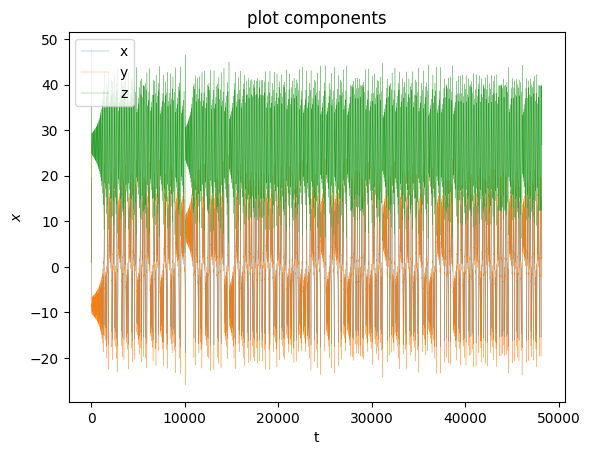

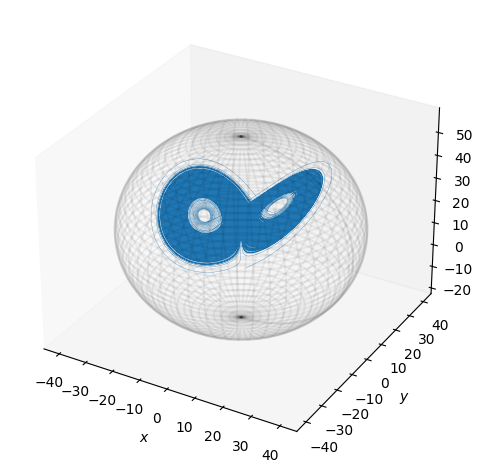

In [9]:
# 初期値の設定
x0 = np.array([1., 1., 1.])

p = (s, r, b)
# 任意のスキームでLorenz63を計算，plotする．
# 引数: scheme(f, t, x, dt) -> x(t+dt)
result = np.zeros((N,len(x0)))
x = x0
result[0] = x[:]

for n in range(1,N):
    t = n*dt
    x = rk4(lorenz63, t, x, p, dt)
    result[n] = x[:]
    
fig1, ax1, fig2, ax2 = plot_lorenz63(result)
rad = 40 # Fix
center = (0, 0, (s+r)/2)
plot_ball(rad, center, ax2)
fig2.tight_layout()
fig2.savefig("l63_ball.pdf", transparent=True)

x_true_full = result[spin_up:]
x_true = x_true_full[::obs_per]

np.save(f"x_true_l63_full", x_true_full)
np.save(f"x_true_l63_per{obs_per}", x_true)

In [10]:
import seaborn as sns
import plotly.io as pio
import plotly.graph_objects as go
from matplotlib.colors import to_hex
pio.renderers.default = 'notebook'

n_colors = 10
pallet_name = "ch:s=-.2,r=.6" # ["rocket_r", "ch:s=-.2,r=.6"]


# plot
colors = sns.color_palette(pallet_name, as_cmap=False, n_colors=n_colors)
data = []
for i in range(10):
    color = to_hex(colors[i])
    X, Y, Z = result[i*len(result)//10:(i+1)*len(result)//10].T
    data.append(go.Scatter3d(x=X, y=Y, z=Z, mode='markers', marker=dict(size=0.3, color=color)))

# add data
fig = go.Figure(data=data)
fig.update_layout(
    width=400,
    height=400,
    showlegend=False,
    scene = dict(
        xaxis = dict(visible=False),
        yaxis = dict(visible=False),
        zaxis =dict(visible=False)
        )
    )
fig.show()

## 観測

In [11]:
# obs variance (R = r0*I)
r0 = 1

In [ ]:
x_true = np.load("x_true_l63_full.npy")
np.random.seed(0)
noise = np.random.normal(loc=0, scale=np.sqrt(r0), size=x_true.shape) # R = r0*I
x_obs = x_true + noise
print(x_obs.shape)

np.save("x_obs_l63", x_obs)

(4000, 3)


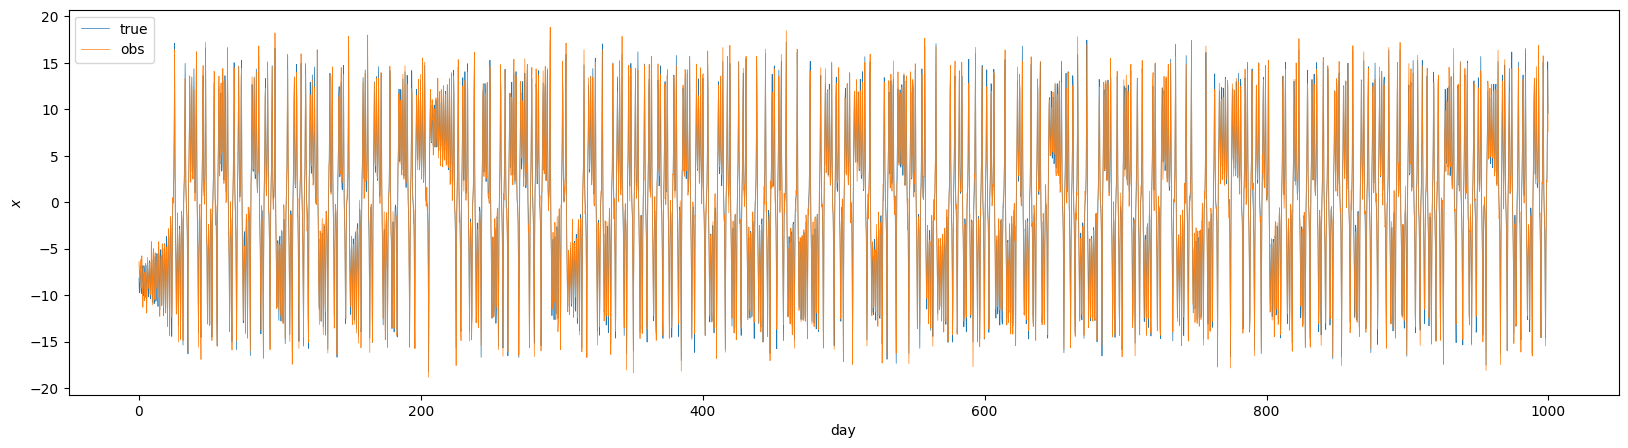

In [13]:
dates = [time/4 for time in range(len(x_true))]
fig1, ax1 = plt.subplots(figsize=(20,5))
ax1.plot(dates, x_true[:, 0], '-', label='true', lw=0.5)
ax1.plot(dates, x_obs[:, 0],'-', label='obs', lw=0.5)
ax1.set_xlabel('day')
ax1.set_ylabel('$x $')
# plt.title('20th component vs. time')
_ = plt.legend()



(0.0, 2.0)

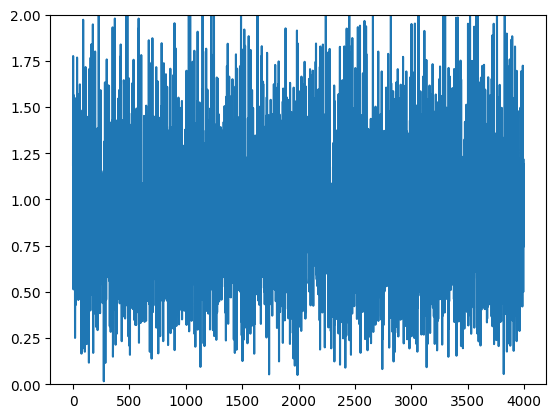

In [14]:
from da.visualize import plot_loss
from da.loss import loss_rms

plot_loss(x_true, x_obs, loss_rms)
plt.ylim([0, 2])

## 誤差発達

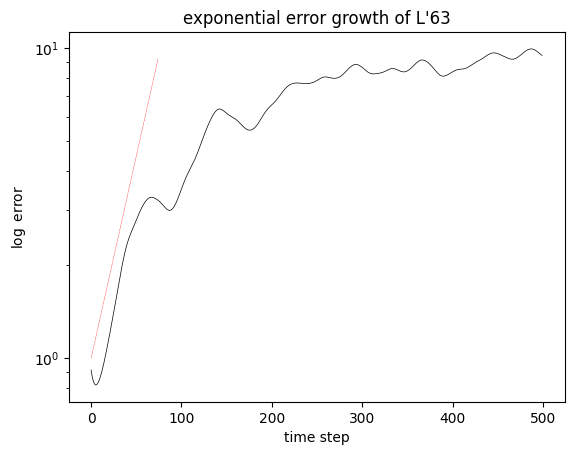

In [15]:
# attractorのデータ
x_atr = result

# dt: 時間刻み
dt = 0.01

p = (s, r, b)

# step数
N_step = 500

# atrからのサンプル数
N_atr_sample = len(x_atr)//(2*N_step)

# ノイズについてのサンプル数
N_noise_sample = 5

# 時間刻み幅
dt = 0.01

# 摂動の大きさ
epsilon = 1

error = np.zeros((N_atr_sample, N_step))
np.random.seed(1)

for m in range(N_atr_sample):
#     半分以降の軌道からサンプル
    z0 = x_atr[spin_up+N_step*m, :]
    z = np.zeros((N_step, 3))
    z[0] = z0
    
    temp_error = np.zeros((N_noise_sample, N_step))
    
    for i in range(N_noise_sample):
        z_perturb = z[0] + epsilon*np.random.normal(size=z[0].shape)
        temp_error[i, 0] = np.linalg.norm(z[0] - z_perturb, ord=2)/np.sqrt(3)
    
        for n in range(1, N_step):
            t = n*dt
            if i == 0:
                z[n] = rk4(lorenz63, t, z[n-1], p, dt)
            z_perturb = rk4(lorenz63, t, z_perturb, p, dt)
            temp_error[i, n] = np.linalg.norm(z[n] - z_perturb, ord=2)/np.sqrt(3)
            
    error[m] = temp_error.mean(axis=0)[:]

error_mean = error.mean(axis=0)

# plot
# logを取ったものもplot
beta = 3.0
n = np.arange(len(error_mean))
fig1, ax1 = plt.subplots()
ax1.plot(error_mean, lw=0.5, c="k")
ax1.plot(np.exp(beta*n*dt)[:75], lw=0.3, c="r", ls="--")
ax1.set_yscale("log")
ax1.set_ylabel(r"$\log$ error")
ax1.set_xlabel("time step")
ax1.set_title("exponential error growth of L'63")
# plt.grid()
fig1.savefig("l63_error_development.pdf", transparent=True)

## アンサンブル予測

[]

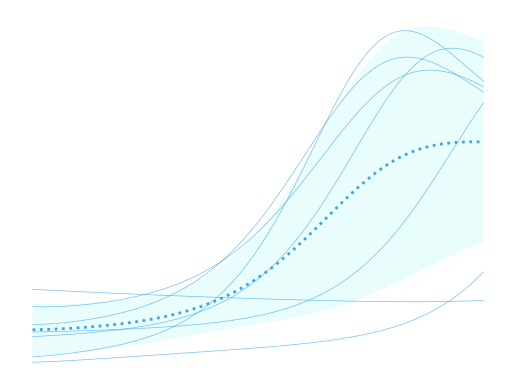

In [16]:
from mpl_toolkits.axisartist.axislines import SubplotZero # 軸の端を矢印にする

# attractorのデータ
x_atr = result

p = (s, r, b)

# step数
N_step = 300

# サンプル数
N_ens = 7


# 時間刻み幅
dt = 0.001

# 摂動の大きさ
epsilon = 4

np.random.seed(1)
m = 4
z0 = x_atr[m]
z = np.zeros((N_step, 3))
z[0] = z0
z_ens = np.zeros((N_ens, N_step, 3))
z_ens[:, 0] = z0

for i in range(N_ens):
    z_perturb = z[0] + epsilon*np.random.normal(size=z[0].shape)

    for n in range(N_step):
        t = n*dt
        z_perturb = rk4(lorenz63, t, z_perturb, p, dt)
        z_ens[i, n] = z_perturb
z_mean = z_ens.mean(axis=0)
z_dev = z_ens.std(axis=0, ddof=1)
# plot
plt.rcParams["font.size"] = 20
fig = plt.figure()
ax = SubplotZero(fig, 111)
fig.add_subplot(ax)
t = np.arange(N_step)
for z in z_ens:
    ax.plot(z[:, 2], lw=0.5, c="#3da6e3", alpha=0.7)
ax.plot(z_mean[:, 2], lw=2, c="#3da6e3", ls="dotted")
ax.fill_between(t[:], z_mean[:, 2]+z_dev[:, 2], z_mean[:, 2]-z_dev[:, 2], alpha=0.1, color="#24f0e9", edgecolor=None)
# ax.set_ylabel("space")
# ax.set_xlabel("time")
for direction in ["right", "top"]:
    ax.axis[direction].set_visible(False)
for direction in ["left",  "bottom"]:
    # ax.axis[direction].set_axisline_style("->")
    ax.axis[direction].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
# fig.savefig("ens_pred.pdf", dpi=300, transparent=True)